#### Water-mass Methods Package
##### BSP Tutorial by Taimoor Sohail and Neill Mackay

This tutorial script runs the Binary Space Partitioning Code on NEMO model data

In [1]:
## Import the BSP component of the WM_Methods package
from WM_Methods import BSP
## Other required packages for calculations and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import xarray as xr
import sys
from tqdm.notebook import tqdm


In [2]:
chunks = {'time': 1}

## Load a text file that includes the list of strings pointing to the relevant data. 
## This ensures that pull requests don't continuously overwrite hardcoded file paths.

filename = 'folders_list.txt'
with open(filename) as f:
    mylist = f.read().splitlines() 

## Load the data using xarray. 

NEMO_historical_tracers = xr.open_mfdataset(mylist[0], decode_times=True, chunks = chunks)
NEMO_historical_fluxes = xr.open_mfdataset(mylist[1], decode_times=True, chunks = chunks)
NEMO_historical_TS = xr.open_mfdataset(mylist[2], decode_times=True, chunks = chunks)

print(NEMO_historical_tracers)

## Align time axis across all datasets
NEMO_historical_tracers.coords['time'] = NEMO_historical_TS['time']

## Grid co-ordinates have an unnecessary 'time' dimension which is dropped here. 

NEMO_historical_tracers['nav_lat'] = NEMO_historical_tracers['nav_lat'].isel(time=0).drop('time')
NEMO_historical_tracers['nav_lon'] = NEMO_historical_tracers['nav_lon'].isel(time=0).drop('time')
NEMO_historical_tracers['cell_area'] = NEMO_historical_tracers['cell_area'].isel(time=0).drop('time')
NEMO_historical_TS['nav_lat'] = NEMO_historical_TS['nav_lat'].isel(time=0).drop('time')
NEMO_historical_TS['nav_lon'] = NEMO_historical_TS['nav_lon'].isel(time=0).drop('time')
NEMO_historical_TS['cell_area'] = NEMO_historical_TS['cell_area'].isel(time=0).drop('time')
NEMO_historical_fluxes['nav_lat'] = NEMO_historical_fluxes['nav_lat'].isel(time=0).drop('time')
NEMO_historical_fluxes['nav_lon'] = NEMO_historical_fluxes['nav_lon'].isel(time=0).drop('time')
NEMO_historical_fluxes['cell_area'] = NEMO_historical_fluxes['cell_area'].isel(time=0).drop('time')

## Load the 9 basins masks

NEMO_mask = xr.open_mfdataset(mylist[3] ,decode_times=True, chunks = chunks)

## The mask file has different names for the dimensions and \
# co-ordinates - here I rename the co-ordinates to be the same as the native NEMO names

NEMO_mask_renamed = NEMO_mask.rename_dims(dict(lev='deptht'))\
.rename(dict(lev='deptht'))

<xarray.Dataset>
Dimensions:    (deptht: 75, time: 39, x: 362, y: 332)
Coordinates:
  * time       (time) datetime64[ns] 1980-06-16T20:00:00 ... 2018-06-17T02:00:00
  * deptht     (deptht) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: x, y
Data variables:
    nav_lat    (time, y, x) float64 dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
    nav_lon    (time, y, x) float64 dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
    cell_area  (time, y, x) float64 dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
    DiC        (time, deptht, y, x) float64 dask.array<chunksize=(1, 75, 332, 362), meta=np.ndarray>
    Cstar      (time, deptht, y, x) float64 dask.array<chunksize=(1, 75, 332, 362), meta=np.ndarray>


In [3]:
## Specify tracers
NEMO_C_star = NEMO_historical_tracers.Cstar

## Define grid area, volume and depth, as well as land mask
NEMO_land_mask = (NEMO_C_star/NEMO_C_star)

NEMO_area = NEMO_historical_tracers.cell_area*NEMO_land_mask.isel(deptht=0)
NEMO_depth = NEMO_historical_tracers.deptht.values

dArea_3D = NEMO_area.expand_dims({'deptht':NEMO_depth.size},axis=1).assign_coords(deptht=NEMO_depth)
dSArea_3D = dArea_3D.copy(deep=True)

## Define grid area, volume and depth, as well as land mask

NEMO_volume = dArea_3D*NEMO_historical_TS.e3t
vol500 = NEMO_volume.copy(deep=True)
depth_ind = np.argmin(NEMO_depth<500)

# Creating 4D mask
NEMO_mask_4D = NEMO_mask_renamed.expand_dims({'time':NEMO_historical_tracers.time.size},axis=1)\
.assign_coords(time=NEMO_historical_tracers.time)
# Defining 9 basins
Basins = NEMO_mask.Basins.values

## Specify T,S
NEMO_T = NEMO_historical_TS.votemper
NEMO_S = NEMO_historical_TS.vosaline

## Flatten variables of interest into 2D arrays (time x flattened spatial dimensions)

vol_500_flattened = vol500.stack(z=("y", "x", "deptht"))
bigthetao_flattened = (NEMO_T.stack(z=("y", "x", "deptht")))
so_flattened = (NEMO_S.stack(z=("y", "x", "deptht")))
C_star_flattened = (NEMO_C_star.stack(z=("y", "x", "deptht")))
mask_flattened = (NEMO_mask_4D.mask_NEMO.stack(z=("y", "x", "deptht")))

## Shorten their names (not necessary but makes for easier code readability)

BA = mask_flattened
V500 = vol_500_flattened
S = ((so_flattened))
T = ((bigthetao_flattened))
C_star = C_star_flattened

## We set our volume array that will be used for binning to be zero below a given depth

vol500[:,depth_ind:,:,:] = 0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

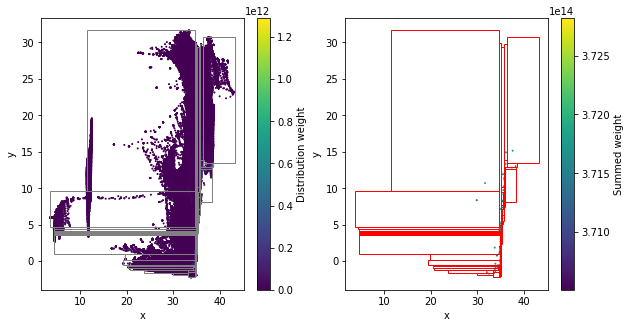

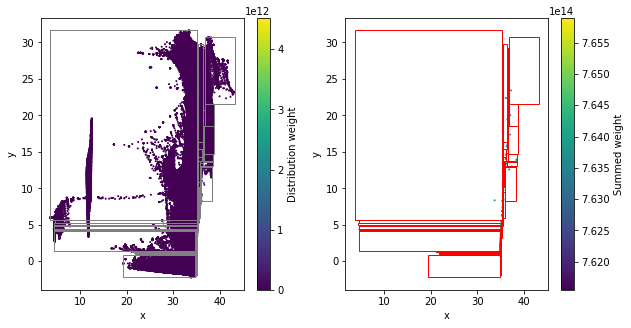

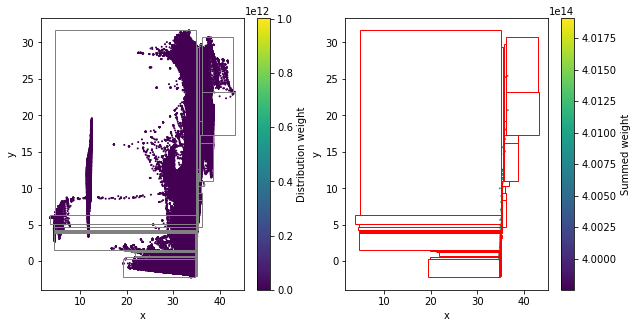

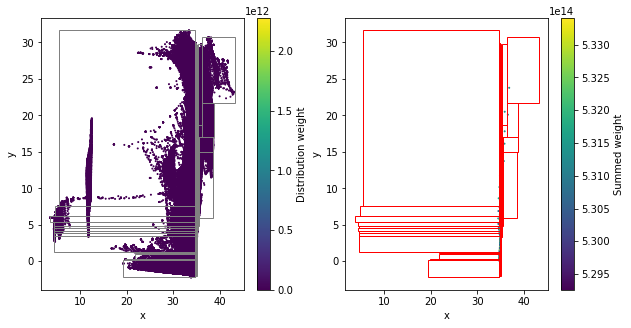

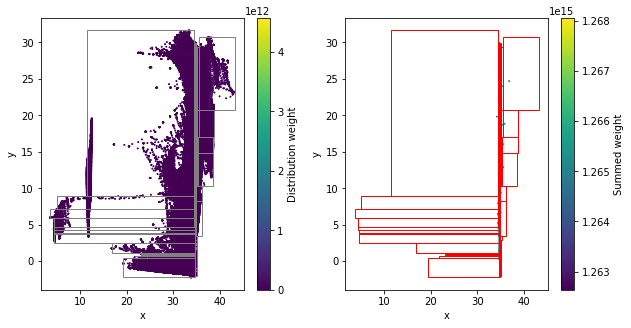

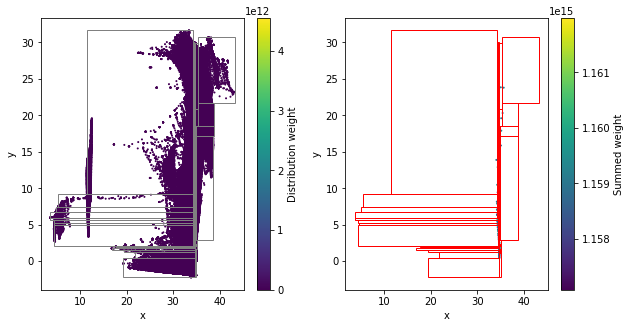

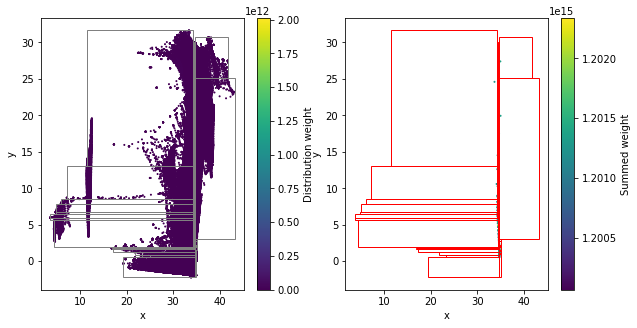

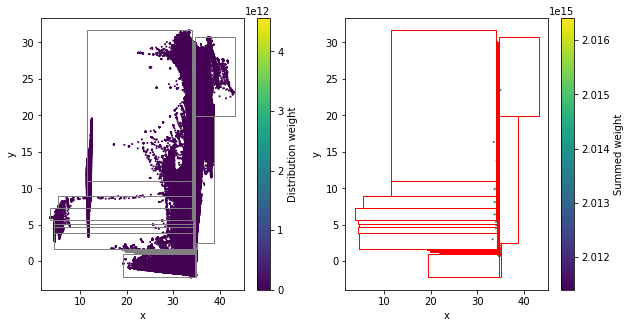

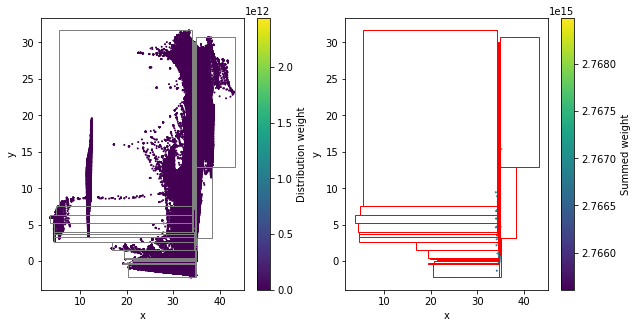

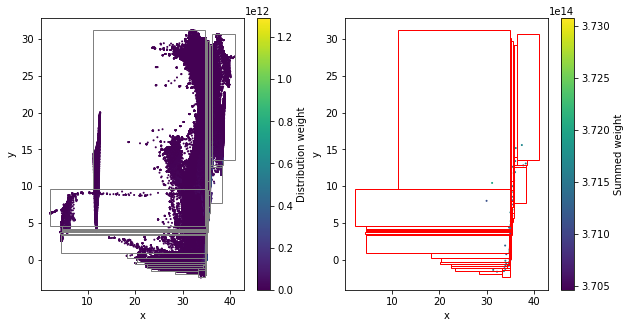

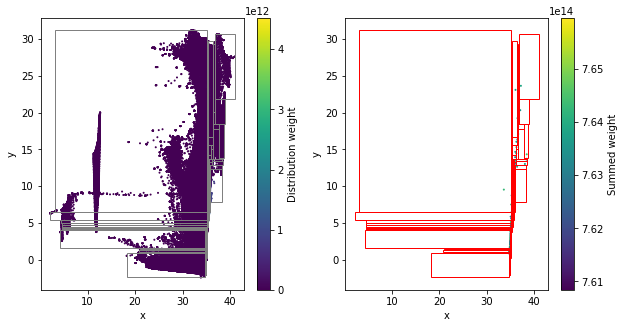

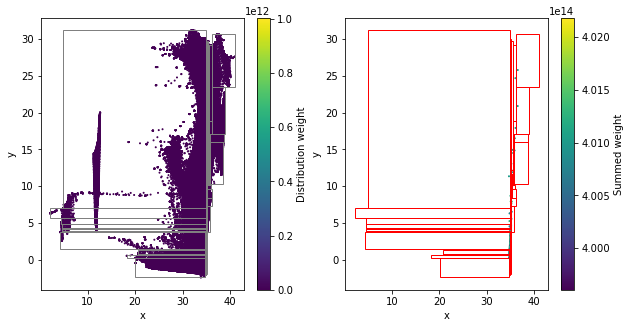

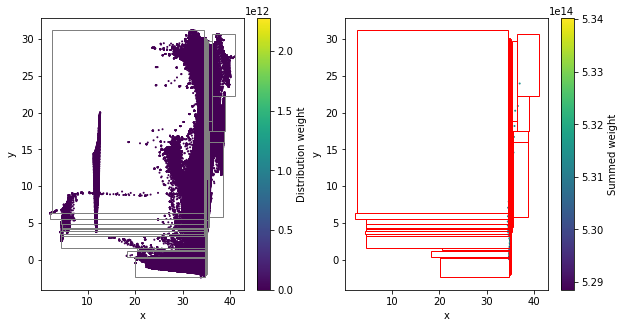

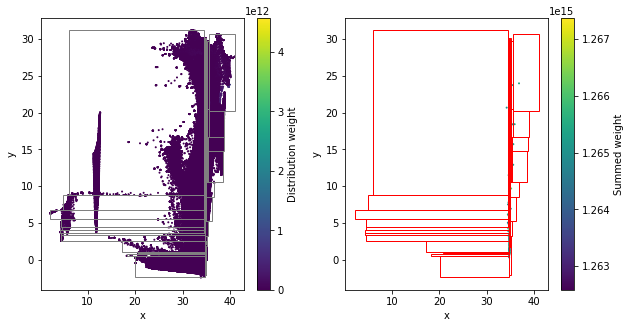

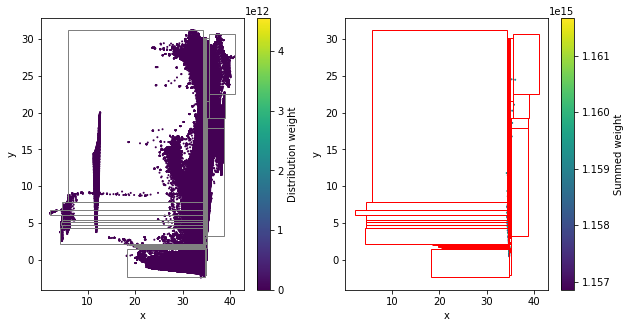

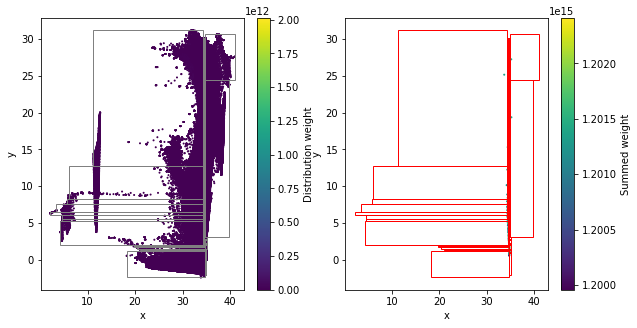

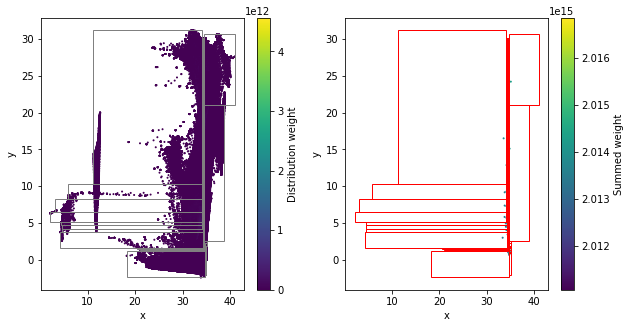

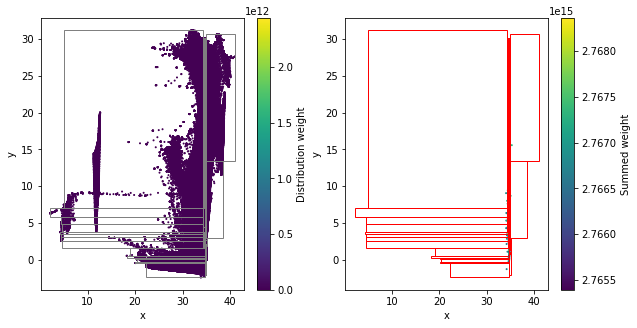

In [22]:
## Define the number of BSP bins to output, where number = 2**tree_depth
tree_depth = 7
# Note: if 2**depth approaches the sample size, the code will not work as an equal volume constraint will become impossible!

## Define the window of time over which BSP bins are calculated - this is important when parallelising this process
window = 2
ti = 0 #int(sys.argv[1])

## Create empty arrays that will be filled by the BSP-ised bins
## Array sizes are (Basin, time, BSP depth) other than for the bin corners which are
## (Basin, time, BSP depth, 4)

partitions_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**tree_depth, 4))
T_mean_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**tree_depth))
S_mean_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**tree_depth))
C_star_mean_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**tree_depth))
V_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**tree_depth))
V500_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**tree_depth))
A_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**tree_depth))
hfds_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**tree_depth))
wfo_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**tree_depth))
Cflux_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**tree_depth))

## Run a loop over times and basins

'''
1) calc: This function calculates the BSP bins for any 2D distribution. We input the x,y, and v parameters, as well as the 
tree depth, first axis to split orthogonal to, and any diagnostics we want to output. 
We are able to output summed variables for each bin, and meaned variables for each bin.
The weight over which the mean is calculated can also be different to the distribution weight, v.

2) split: The `calc` function outputs a large nested list, which needs to be split into the constituent diagnostics of interest. 
Due to the recursive nature of the `calc` function, this splitting must be accomplished in a second function, `split`.
The output of the `split` function is a dictionary with BSP box boundaries, summed variables and meaned variables. 

3) draw: The `draw` function allows us to visualise the BSP boundaries on top of the original distribution. 
'''

time_array = np.zeros(window)

for i in tqdm(range(ti*window, (ti+1)*window)):
    time_array[int(i-ti*window)] = i
    for j in tqdm(range(Basins.size)):
        # Get a single timestep as numpy, not dask
        ## The x and y axes
        x = S[i,:].values
        y = T[i,:].values
        ## Any tracers to find the weighted mean of
        z = C_star[i,:].values
        ## The 2D distribution to calculate bins on
        v = V500[0,:].values*BA[j,i,:].values
               
        
        # Clean out NAN values
        idx = np.isfinite(x)
        x = x[idx]
        y = y[idx]
        z = z[idx]
        v = v[idx]      

        ## Calculate the BSP bins
        BSP_out = BSP.calc(x,y, v, depth=tree_depth, axis=1, mean=[x,y,v],sum=[v],weight=v)
        # Split the output into constituent diagnostics
        vals = BSP.split(BSP_out, depth=tree_depth)
        ## Draw the BSP bins onto original grid

        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(1,2,1)
        BSP.draw(x,y,v,vals['bounding_box'],'grey', depth=tree_depth)
        cbar = plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        cbar.set_label('Distribution weight')
            
        ax = fig.add_subplot(1,2,2)
        BSP.draw(vals['meaned_vals'][:,0],vals['meaned_vals'][:,1],vals['summed_vals'],vals['bounding_box'],'red', depth=tree_depth, cmap=plt.cm.viridis)
        cbar = plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        cbar.set_label('Summed weight')
        
        if i == 1:
            plt.show()
            
        ## The BSP results come out as a long list of different numbers in the format
        ## [bounds, xmean, ymean, zmean, vsum, csum,  asum, usum, wsum, qsum], where bounds 
        ## itself is a tuple (x0,y0,x1,y1).
        ## Below, we split the list into arrays of each variable

#        bsp_flat = list(itertools.chain(*BSP_out))
#
#        while (len(bsp_flat) <= 2**tree_depth):
#            bsp_flat = list(itertools.chain(*bsp_flat))
#        partitions_hist[j,int(i-ti*window),:,:] = np.array(bsp_flat[::11])
#        T_mean_hist[j,int(i-ti*window),:] = np.array(bsp_flat[1::11])
#        S_mean_hist[j,int(i-ti*window),:] = np.array(bsp_flat[2::11])
#        C_star_mean_hist[j,int(i-ti*window),:] = np.array(bsp_flat[3::11])
#        V500_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[4::11])
#        V_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[5::11])
#        A_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[6::11])
#        hfds_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[7::11])
#        wfo_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[8::11])
#        Cflux_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[9::11])
        


In [ ]:
## We redefine each outputted numpy array as an xarray DataArray with the goal of saving it as a netCDF file

da_partitions_hist = xr.DataArray(data = partitions_hist, dims = ["Basin","Time", "Depth", "Coords"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth= np.arange(2**depth), Coords = np.arange(4)),
                        attrs=dict(description="[x0,y0,xmax,ymax] bounds of BSP framework", variable_id="Partitions"))
da_S_mean_hist = xr.DataArray(data = S_mean_hist, dims = ["Basin", "Time", "Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Mean Salinity", units="g/kg", variable_id="S"))
da_T_mean_hist = xr.DataArray(data = T_mean_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Mean Temperature", units="K", variable_id="T"))
da_C_star_mean_hist = xr.DataArray(data = C_star_mean_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Mean C_star", units="mmol-C/m3", variable_id="C_star"))
da_V_sum_hist = xr.DataArray(data = V_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Total Volume", units="m^3", variable_id="Basin V_sum"))
da_A_sum_hist = xr.DataArray(data = A_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Total Area", units="m^2", variable_id="Basin A_sum"))
da_hfds_sum_hist = xr.DataArray(data = hfds_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Heat Flux", units="W", variable_id="hfds"))
da_wfo_sum_hist = xr.DataArray(data = wfo_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="FW Flux", units="kg/s", variable_id="wfo"))
da_Cflux_sum_hist = xr.DataArray(data = Cflux_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Carbon Flux", units="mmol-C/s", variable_id="Cflux"))

## Input all xarray DataArrays into a DataSet

ds_BSP = xr.Dataset()
ds_BSP['Partitions_hist'] = da_partitions_hist
ds_BSP['T_mean_hist'] = da_T_mean_hist
ds_BSP['S_mean_hist'] = da_S_mean_hist
ds_BSP['C_star_mean_hist'] = da_C_star_mean_hist
ds_BSP['V_sum_hist'] = da_V_sum_hist
ds_BSP['A_sum_hist'] = da_A_sum_hist
ds_BSP['hfds_sum_hist'] = da_hfds_sum_hist
ds_BSP['wfo_sum_hist'] = da_wfo_sum_hist
ds_BSP['Cflux_sum_hist'] = da_Cflux_sum_hist

ds_BSP.to_netcdf(mylist[4]+'BSP_NEMO_TS_hist_area_%i_%i.nc' %(ti*window, (ti+1)*window-1))

In [21]:
BSP_out

[[[[[[[[(29.9130246001429,
         33.29457038544744,
         -1.8708712969371526,
         -1.6237722477784688),
        array([3.7156311e+14]),
        array([ 3.24359519e+01, -1.69991957e+00,  1.34805412e+10]),
        None],
       [(23.67822283704714,
         33.29453845382739,
         -1.623769479864343,
         -1.1904439858010092),
        array([3.71601515e+14]),
        array([ 3.20217581e+01, -1.49657139e+00,  1.98901922e+10]),
        None]],
      [[(33.294595841789146,
         34.68225814561691,
         -2.222546926160326,
         -1.4877976926217826),
        array([3.71559665e+14]),
        array([ 3.35750129e+01, -1.61087670e+00,  2.83955038e+10]),
        None],
       [(33.29464366178055,
         34.68166474582879,
         -1.4877956366055283,
         -1.1904233621323443),
        array([3.71607624e+14]),
        array([ 3.38390993e+01, -1.33603357e+00,  4.07153959e+10]),
        None]]],
     [[[(20.682729919928043,
         34.32283660600576,
         -1